In [ ]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from itertools import islice
from tqdm import tqdm

wandb.login()

wandb_entity = os.environ.get('WANDB_ENTITY')
api = wandb.Api()
api.flush()
all_runs = api.runs(f'{wandb_entity}/reacher-bench', per_page=100)
histories = []
for i, run in enumerate(tqdm(all_runs)):
    if run.config['EPS_DECAY'] != 1:
        continue
    if run.config['NOISE_STDDEV'] != 0.85:
        continue
    history = run.history(samples=1000)  # necessary or wandb will randomly sample
    history['HIDDEN_SIZE_1'] = run.config['HIDDEN_SIZE_1']
    history = history[['_step', 'scores', 'HIDDEN_SIZE_1']]
    history['run'] = run.id
    histories.append(history)

combined = pd.concat(histories)
combined = combined[combined._step < 1000]
h_128 = combined[combined.HIDDEN_SIZE_1 == 128].reset_index()
h_256 = combined[combined.HIDDEN_SIZE_1 == 256].reset_index()


# Introduction

This project implements a deep reinforcement learning algorithm to solve a problem involving moving a double jointed arm around an environment.  The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.  The problem is considered solved when the algorithm manages to average a score over 30 for a period of 100 episodes.

# The Problem

## Reinforcement Learning

The general idea behind reinforcement learning is this:

* problem can be represented as a sequence of states, actions, and rewards ${s_0, a_0, r_1, s_1, a_1, \ldots, s_n, a_n, r_n}$
* a solution to a problem can be represented as a mapping of states $s\in S$ to actions $a\in A$, where each action results in a reward $r\in R$ and a subsequent state $s'\in S$
* the best action(s) can be selected by estimating the expected long term reward received by performing a given action in a given state.
* the long term reward can be shaped by applying a discount factor $\lambda$ (in this implementation, 0.99) to encourage getting rewards sooner rather than later

These ideas can be combined into a family of equations collectively referred to as Bellman equations, for example this one which expresses it in terms of states and actions:

$$Q(s,a) = E\left[ \sum_{t=0}^\infty \lambda^t R_{t+n} |S=s_n, A=a_n\right]$$

## Q Learning

The main idea of Q learning is that if we can estimate the best possible average reward that can be gained from the state that follows our current state after performing a given action, we can use that estimate as a substitute for the rest of the infinite sum, which lets us use this equation instead.

$$Q(s, a)=E\left[R_t + \lambda \text{max} Q_b(S_{t+1}, b) | S_t=s, A_t=a \right]$$

To converge on this value, we randomly initialize an estimate of $Q(s, a)$ for all $s\in S, a\in A$, then sample the environment repeatedly to get tuples of (state, action, reward, next_state) and update our estimate of the value $Q(s, a)$ using this iterative algorithm. where $\alpha$ represents the degree to which we shift our estimate towards the immediately perceived combination of immediate reward and estimated future reward:

$$Q(s, a)=Q(s, a) + \alpha\left[r + \lambda \text{max}_{b} Q(s', b) - Q(s, a)\right]$$

this inner expression is frequently extracted and referred to as the TD-error:

$$\delta = r + \lambda \text{max}_{b} Q(s', b) - Q(s, a)$$

In order to focus in on the best strategies in a large state space, we begin by exploring random choices and gradually adjust our behaviour to exploit the best known actions.  This is done by employing a strategy called $\epsilon$-greedy, where $\epsilon$ represents the percentage of time that a random action is selected, while $1-\epsilon$ is the chance that we will exploit the best estimated action.  For this solution, we start with $\epsilon=1$ and decay at a rate of $0.995$ per episode down to a minimum of $\epsilon=0.1$.

For relatively small state/action spaces, it's possible to represent them as a simple matrix of $S \times A$.  This is commonly referred to as tabular Q learning.

As the size of the state space can exceed the capacity of computers to store the entire space in its exact form, function approximation is used to calculate a representation.  Instead of storing the Q values in a matrix, instead a function $Q(s, a|\theta)$ is learned, where $\theta$ generally represents an array of weights which are learned using gradient descent.

In the gradient descent process, the $\alpha$ from the tabular system is essentially equivalent to the learning rate in the gradient descent optimizer.

## Deep Deterministic Policy Gradients

Environments with continuous action spaces pose new problems.  Since the number of possible actions is infinite, it's no longer feasible to try to estimate the Q values for each possible action.  DDPG extends regular Q learning by training two separate estimators (sometimes with some shared weights) to learn the best action $a$ (referred to as the Actor) as well as $\text{max}_a Q(a)$ (referred to as the Critic).  Additionally, like in DQN, target networks are used to improve stability.

The two estimators interact such that:

The actor $Actor(s)$ predicts an action based on state

The critic $Critic(s, a)$ predicts a Q value based on state and action

The critic improves itself in much the same way that a regular DQN works using gradient descent to zero in on a good estimate of $Q(s,a)$.  By using the action as an input to the critic network it structures the problem of choosing the best action as a differentiable function of the critic network which directly generates a reward estimate allowing improvement through gradient ascent.

### Critic

At each learning step, the critic improves itself by taking an experience tuple s,a,r,s' and calculating:

$$a' = \text{Actor}_\text{local}(s)$$
$$q_\text{local} = r + \text{Critic}_\text{local}(s', a')$$

Then the target network is used to estimate the current $\text{max}_a Q(s, a)$

$$q_\text{target} = \text{Critic}_\text{target}(s, a)$$

and the mean squared error between $q_\text{local}$ and $q_\text{target}$ is used to update the local network, resulting in a model that can more accurately estimate the long term reward from taking a given action.

### Actor

The predicted action from the actor network can be used as an input to the critic network for the starting state.  As this predicts the long term cumulative reward $R$ for following this action, we can improve the actor's prediction by backpropagating along the gradient in the direction that locally improves the critic's predicted value.

$$\Delta R=\Delta \text{Critic}_\text{local}\left(s, \text{Actor}_\text{local}(s)\right)$$

Both the actor and critic target models are updating using soft updates, where after each round of learning a fraction of the weights are transferred from the local network to the target.

## Exploration

With DQN, exploration is achieved through $\epsilon$-greedy strategies.  Since the Actor network outputs a deterministic estimate of the best predicted action, random noise is added to the actions during training.  The original paper suggested using Ornsteun-Uhlenbeck process generated noise, however experimentation on this particular problem seems to indicate that simple Gaussian noise performs better and is less complicated.

## Experience Replay

Like DQN, DDPG uses experience replay.  With experience replay, the agent gathers tuples (experiences) of $(s, a, r, s')$ and stores them in a fixed length FIFO queue (in this implementation, up to 1000000 experiences).  Periodically (in this implementation, every 20 actions), the agent samples a subset of experiences from this buffer (in this implentation, a batch size of 128 experiences) and applies the iterative update algorithm described above to move the estimator closer to an optimal strategy.  This solves two main issues:

First of all, the cost of gathering samples can be prohibitive.  By reusing samples several times, we extract more value from each individual experience.  In this algorithm, a sample is reused on average 8 times.

Second, a sequence of actions that are experienced by an agent are likely to be highly correlated, which if used in the order they are found will result in heavily biased learning that can focus in on a certain part of the state/action space and cause catastrophic forgetting of lessons learned from distantly prior experiences.  By introducing an element of random selection in the batch selection, this produces less correlated training data and correspondingly better learning.

# Hyperparameters

*    n_episodes (int): number of training episodes
*    max_t (int): maximum number of timesteps per episode
*    noise_stddev (float): the standard deviation of the gaussian noise to add to the actions for exploration purposes
*    buffer_size (int): maximum size of the replay buffer
*    hidden_size_1 (int) the size of the first hidden layer
*    hidden_size_2 (int) the size of the second hidden layer, less the action size in the case of the critic
*    learn_every (int): how often to apply the iterative update algorithm, in steps
*    learn_cycles (int): the number of mini batches to learn every `learn_every` steps
*    batch_size (int): the size of the mini batches
*    tau (float): the rate of copying the live network weights into the target network as part of the soft update
*    actor_lr (float): learning rate for actor's optimizer
*    critic_lr (float): learning rate for the critic's optimizer
*    gamma (float): discount factor for transfering future rewards back down the chain, normally denoted $\lambda$


# Model architecture

The two models make use of entirely separate networks.  The actor model computes an action vector based on the state using a two layer network using ReLU non-linearities and a tanh layer at the end to implicitly constrain the outputs to the desired range of $(-1, 1)$.  The critic model takes a state, passes that through a single layer before concatenating the action vector and passing it through a second linear layer with no additional processing as the Q values are not bounded.

## Actor Model

In [ ]:
class ActorModel(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size_1=128, hidden_size_2=256):
        """
        :param state_size (int):
        :param action_size (int):
        :param seed (int): random seed
        :param hidden_size_1 (int):
        :param hidden_size_2 (int):
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, action_size)
        self.batchnorm_1 = nn.BatchNorm1d(hidden_size_1)

    def forward(self, state):
        x = F.relu(self.batchnorm_1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


## Critic Model

In [ ]:
class CriticModel(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size_1=128, hidden_size_2=256):
        """
        :param state_size (int):
        :param action_size (int):
        :param seed (int): random seed
        :param hidden_size_1 (int):
        :param hidden_size_2 (int):
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1+action_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, 1)
        self.batchnorm_1 = nn.BatchNorm1d(hidden_size_1)

    def forward(self, state, action):
        xs = F.relu(self.batchnorm_1(self.fc1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Results

I trained the agent over 50 episodes and found that on average it solved the environment in approximately 165 episodes.  The error band in the graph below is the standard deviation in score.

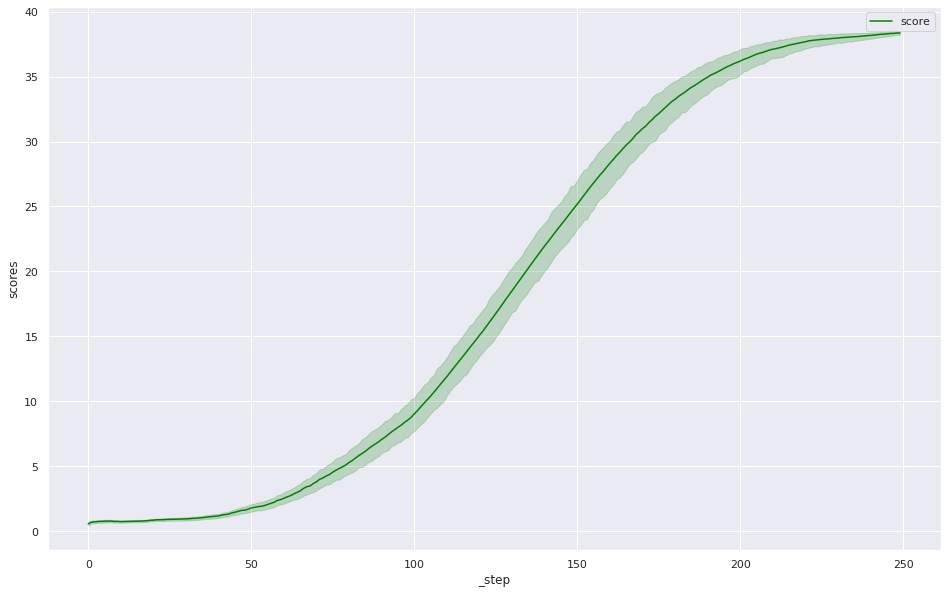

In [11]:
import seaborn as sns
sns.set(rc={'figure.figsize': (16, 10)})
sns.set_theme(style='darkgrid')
sns.lineplot(data=h_128, x='_step', y='scores', color='green')
plt.legend(labels=[
    'score',
])

In [149]:
combined.groupby(['_step', 'DOUBLE_DQN']).mean().query('scores >= 13').reset_index().groupby('DOUBLE_DQN').min()[['_step']] - 100

,_step
DOUBLE_DQN,
False,571
True,478


In [ ]:
sns.lineplot(data=double_dqn, x='_step', y='scores', color='green')
sns.lineplot(data=dqn, x='_step', y='scores', color='red')
plt.legend(labels=[
    'double dqn score',
    'dqn score',
])

# Ideas for Future Work

## Hyperparameter Tuning

The most likely target for easy gains is more hyperparameter tuning, particularly in the network size parameters.

## Noise decay

Currently the code uses a static noise parameter throughout the entirety of training, but it seems likely that some means of decaying the noise would have positive effects if not in terms of time to solve, then in terms of long run highest score.  Limited experimentation has not yet resulted in any benefit though.

## Prioritized Experience Replay

Prioritized Experience Replay uses the estimated difference between the current network's model and the targets to focus the replay buffer on areas of greatest potential improvement.

## Sharing weights between actor and critic

Currently the two networks are entirely separate, however the critic and actor networks are identical in structure in their first layer, and could probably benefit from sharing weights between them.